In [1]:
import math
import collections
import pickle
import random
import scipy
import json

from matplotlib import pyplot as plt

import GPy
import numpy as np
import pandas as pd
from tqdm import tqdm

# from Kernel import MixtureViaSumAndProduct, CategoryOverlapKernel
from InitialData_Gen import initialize
from AcquisitionFunctions import EI, PI, UCB, AcquisitionOnSubspace
# from SamplingCategorical import compute_prob_dist_and_draw_hts
from UpdateCategoricalWeight import compute_reward_for_all_cat_variable, update_weights_for_all_cat_var
from optimization import sample_then_minimize

from AskTell import ask_tell

from scipy.optimize import minimize

from typing import Union, Tuple
from paramz.transformations import Logexp

1. C - List of number of categroies corresponding to each categorical variable
2. Nc - Number of categorical variables
3. Nx - Continuous variables
4. h - categorical
5. x - continuous
6. z - [h, x]

7. nDim - Nc + Nx
8. bounds - Lower and Upper bounds of both Catergorical variables and continuous variables

9. n_iter - Number of iterations to run the algorithm
10. initN - Number of intial data points
11. batch_size (b) - Number of experiments to be generated in each iteration

12. acq_type - Acquisition Type ('EI', 'LCB', 'ThompsonSampling')

### 1. Load Model background from the pickle file

In [2]:
import sys
myString = sys.path[0]
split_list = myString.split("/")
root = ''
for l in split_list[1:-2]:
    root = root +'/'+ l
    
main_file_path = root + '/Trastuzumab/'
carbon_source_fiepath = root + '/'

In [3]:
def distr(weights, gamma=0.0):
    theSum = float(sum(weights))
    return tuple((1.0 - gamma) * (w / theSum) + (gamma / len(weights)) for w in weights)

### 2. Read Experimental condition and results 

In [4]:
# Correcting the Wc_list and probabilityDistribution
Wc_list = {}
probabilityDistribution = {}
batch_size = 11
Wc_list[0] = [np.ones(19)]

for All_rounds in range(1, 5):
    background_file = main_file_path +  "Codes/Round"+str(All_rounds)+ "/" + str(All_rounds)+"_ModelBackground.pkl"
    with open(background_file, "rb") as fp:
        ModelBackground_3 = pickle.load(fp)

    probabilityDistribution[All_rounds-1] = [distr(Wc_list[All_rounds-1][0], ModelBackground_3['gamma_list'][0])]
    
    N_round = All_rounds+1
    Design = {}
    Result_df = {}
    for nr in range(N_round):
        file_name = main_file_path + 'Codes/Round' + str(nr) + '/Reconstructed_Round' + str(nr) + '.csv'
        Design[nr] = pd.read_csv(file_name)
        Column_Names = pd.read_csv(file_name).columns

        file_name_res = main_file_path + 'Exp/Round' + str(nr) + '/Round' + str(nr) + '_Result_Summary_final.csv'
        Result_df[nr] = pd.read_csv(file_name_res)
        if nr == 0:
            data_init = Design[nr].iloc[:,1:].values
            result_init = Result_df[nr]['Specific Productivity'].iloc[:-1,].values.reshape(-1,1)
            data_modified = []
            result_modified = []
            for nc in range(data_init.shape[0]):
                if data_init[nc,1] == 0:
                    temp = np.concatenate((np.arange(0,19).reshape(-1,1), 
                                           np.zeros((19,1)), data_init[nc,2] * np.ones((19,1)), data_init[nc,3]*np.ones((19,1))), axis = 1)
                    temp_res = result_init[nc]*np.ones((19,1)) 
                    data_modified + temp.tolist()
                    result_modified + temp_res.tolist()                   
                else:
                    data_modified.append(data_init[nc,:])
                    result_modified.append(result_init[nc]) 

            data_modified_np = np.array(data_modified)
            print(data_modified_np.shape)
            des_bench = np.concatenate((np.arange(0,19).reshape(-1,1), np.zeros((19,1)), 0.4 * np.ones((19,1)), 0.15*np.ones((19,1))), axis = 1)
            data = np.concatenate((data_modified, des_bench), axis = 0)

            result = np.concatenate((np.array(result_modified), Result_df[nr]['Specific Productivity'].iloc[-1,]*np.ones((19,1))), axis = 0)

        else:
            data_init = Design[nr].iloc[:,1:].values

            result_init = Result_df[nr]['Specific Productivity'].iloc[:-1,].values.reshape(-1,1)
            data_modified = []
            result_modified = []
            for nc in range(data_init.shape[0]):
                if data_init[nc,1] == 0:
                    temp = np.concatenate((np.arange(0,19).reshape(-1,1), np.zeros((19,1)), 
                                    data_init[nc,2] * np.ones((19,1)), data_init[nc,3]*np.ones((19,1))), axis = 1)
                    data_modified + temp.tolist()

                    temp_res = result_init[nc]*np.ones((19,1)) 
                    result_modified + temp_res.tolist()
                else:
                    data_modified.append(data_init[nc,:])
                    result_modified.append(result_init[nc]) 

            data_modified_np = np.array(data_modified)

            des_bench = np.concatenate((np.arange(0,19).reshape(-1,1), np.zeros((19,1)), 0.4 * np.ones((19,1)), 0.15*np.ones((19,1))), axis = 1)                               
            
            data = np.concatenate((data, data_modified_np, des_bench), axis = 0)

            result_mod_array = np.array(result_modified)
            result = np.concatenate((result,result_mod_array,Result_df[nr]['Specific Productivity'].iloc[-1,]*np.ones((19,1))), 
                                     axis = 0)
            
        mu_y = np.mean(result, 0)
        std_y = np.std(result, 0)

        result_norm = np.divide((result - mu_y), std_y)
        
        C_list = ModelBackground_3['data_param']['C']

        ht_next_list_array = np.atleast_2d(ModelBackground_3['Categorical_dist_param']['ht_batch_list'])
        ht_list_rewards = compute_reward_for_all_cat_variable(ht_next_list_array, C_list,
                                                      data,result_norm, batch_size) #np.divide(result, np.max(result))
                
        Wc_list [All_rounds] = update_weights_for_all_cat_var(C_list, 
                ht_list_rewards, ModelBackground_3['Categorical_dist_param']['ht_list'],
                Wc_list[All_rounds-1], ModelBackground_3['gamma_list'],
                probabilityDistribution[All_rounds-1],
                batch_size, []) #ModelBackground_3['Categorical_dist_param']['S0']
        
        probabilityDistribution[All_rounds] = [distr(Wc_list[All_rounds][0],  
                                                       ModelBackground_3['gamma_list'][0])]

(23, 4)
(23, 4)
(23, 4)
(23, 4)


In [5]:
background_file = main_file_path +  "Codes/Round4/4_ModelBackground.pkl"
with open(background_file, "rb") as fp:
    ModelBackground_3 = pickle.load(fp)
    
ModelBackground_3['data_param']['Meas_Noise'] = 0.04
ModelBackground_3['data_param']['trade_off'] = 3 * (1.63-0.54)/(2.21-0.54)

In [6]:
N_round = 5
Design = {}
Result_df = {}
for nr in range(N_round):
    file_name = main_file_path + 'Codes/Round' + str(nr) + '/Reconstructed_Round' + str(nr) + '.csv'
    Design[nr] = pd.read_csv(file_name)
    Column_Names = pd.read_csv(file_name).columns
   
    file_name_res = main_file_path + 'Exp/Round' + str(nr) + '/Round' + str(nr) + '_Result_Summary_final.csv'
    Result_df[nr] = pd.read_csv(file_name_res)
    if nr == 0:
        data_init = Design[nr].iloc[:,1:].values
        result_init = Result_df[nr]['Specific Productivity'].iloc[:-1,].values.reshape(-1,1)
        data_modified = []
        result_modified = []
        for nc in range(data_init.shape[0]):
            if data_init[nc,1] == 0:
                temp = np.concatenate((np.arange(0,19).reshape(-1,1), 
                                       np.zeros((19,1)), data_init[nc,2] * np.ones((19,1)), data_init[nc,3]*np.ones((19,1))), axis = 1)
                temp_res = result_init[nc]*np.ones((19,1)) 
                data_modified + temp.tolist()
                result_modified + temp_res.tolist()                   
            else:
                data_modified.append(data_init[nc,:])
                result_modified.append(result_init[nc]) 
                
        data_modified_np = np.array(data_modified)
        print(data_modified_np.shape)
        des_bench = np.concatenate((np.arange(0,19).reshape(-1,1), np.zeros((19,1)), 0.4 * np.ones((19,1)), 0.15*np.ones((19,1))), axis = 1)
        data = np.concatenate((data_modified, des_bench), axis = 0)
        
        result = np.concatenate((np.array(result_modified), Result_df[nr]['Specific Productivity'].iloc[-1,]*np.ones((19,1))), axis = 0)
                                        
    else:
        data_init = Design[nr].iloc[:,1:].values
        
        result_init = Result_df[nr]['Specific Productivity'].iloc[:-1,].values.reshape(-1,1)
        data_modified = []
        result_modified = []
        for nc in range(data_init.shape[0]):
            if data_init[nc,1] == 0:
                temp = np.concatenate((np.arange(0,19).reshape(-1,1), np.zeros((19,1)), 
                                data_init[nc,2] * np.ones((19,1)), data_init[nc,3]*np.ones((19,1))), axis = 1)
                data_modified + temp.tolist()
                
                temp_res = result_init[nc]*np.ones((19,1)) 
                result_modified + temp_res.tolist()
            else:
                data_modified.append(data_init[nc,:])
                result_modified.append(result_init[nc]) 

        data_modified_np = np.array(data_modified)
        
        des_bench = np.concatenate((np.arange(0,19).reshape(-1,1), np.zeros((19,1)), 0.4 * np.ones((19,1)), 0.15*np.ones((19,1))), axis = 1)                               
        print(nr)
        data = np.concatenate((data, data_modified_np, des_bench), axis = 0)
        
        result_mod_array = np.array(result_modified)
        result = np.concatenate((result,result_mod_array,Result_df[nr]['Specific Productivity'].iloc[-1,]*np.ones((19,1))), 
                                 axis = 0)

(23, 4)
1
2
3
4


### 3. Update rewards and weights

In [7]:
batch_size = 11
random.seed(37)

C_list = ModelBackground_3['data_param']['C']

ht_next_list_array = np.atleast_2d(ModelBackground_3['Categorical_dist_param']['ht_batch_list'])

mu_y = np.mean(result, 0)
std_y = np.std(result, 0)

mu_x = np.mean(data, 0)
std_x = np.std(data, 0)

data_norm = (data - mu_x)/std_x
data_norm[:,0] = data[:,0]

result_norm = (result - mu_y)/std_y

ht_list_rewards = compute_reward_for_all_cat_variable(ht_next_list_array, C_list,
                                                      data,result_norm, batch_size) # np.divide(result,np.max(result))

Wc_list[5] = update_weights_for_all_cat_var(C_list, 
                ht_list_rewards, ModelBackground_3['Categorical_dist_param']['ht_list'],
                Wc_list[4], ModelBackground_3['gamma_list'],
                probabilityDistribution[4],
                batch_size, [])#ModelBackground_3['Categorical_dist_param']['S0']

In [8]:
z_next_org, Categorical_dist_param, gp = ask_tell(data, result, ModelBackground_3['data_param'], 
                                          'RBF', 'constant_liar', batch_size, 
                                          Wc_list[5], ModelBackground_3['gamma_list']) #constant_liar, thompson_sampling

check2


In [9]:
counter = 4
z_next = z_next_org
z_next[:,1:] = np.round(z_next[:,1:],2)
pd.DataFrame(z_next).to_csv('./Round5/5_ExperimentalDesign_' +str(counter)+'.csv') #



### 4. Store the Model background parameters

In [10]:
ModelBackground_4 = {}
ModelBackground_4 = {'gamma_list': ModelBackground_3['gamma_list'],  'budget': ModelBackground_3['budget'],
                 'bestUpperBoundEstimate': ModelBackground_3['bestUpperBoundEstimate'], 
                     'Wc_list_init': ModelBackground_3['Wc_list_init'],
                   'Wc_list': Wc_list, 'data_param': ModelBackground_3['data_param'], 
                   'Categorical_dist_param': Categorical_dist_param}

import pickle
with open('./Round5/5_ModelBackground.pkl', 'wb') as output:
    # Pickle dictionary using protocol 0.
    pickle.dump(ModelBackground_4, output)

### 5. Conversion to actual experimental execution

In [11]:
Stock_solid = pd.read_excel(carbon_source_fiepath +'CarbonSourceInfo.xlsx', 'Stocks_solid')
Stock_liquid = pd.read_excel(carbon_source_fiepath + 'CarbonSourceInfo.xlsx', 'Stocks_liquid')

Carbon_Names = Stock_solid['Carbon Source'].values.tolist()
Carbon_Names.append(Stock_liquid['Carbon Source'][1])
Carbon_Names.append(Stock_liquid['Carbon Source'][2])

Carbon_Ub = [50]*17 #[g/L]
Carbon_Ub.append(10) # Glycerol [mL/L]
Carbon_Ub.append(50) #Ethanol [mL/L]

OG_Gly_Ub = 100 #[mL/L]
Met_Ub = 100 #[mL/L]

Stock_Conc = Stock_solid['g/mL'].values.tolist()
Stock_Conc.append(Stock_liquid['mL/mL'][1].tolist())
Stock_Conc.append(Stock_liquid['mL/mL'][2].tolist())

OG_Stock_Conc = Stock_liquid['mL/mL'][0].tolist()



In [12]:
Selected_Carbon = []
Carbon_mL = []
OG_Gly_mL = []
Met_mL = []


for i in range(batch_size):
    Selected_Carbon.append(Carbon_Names[int(z_next[i,0])])
    temp_factor = Carbon_Ub[int(z_next[i,0])]/ Stock_Conc[int(z_next[i,0])]
    temp = z_next[i,1] * temp_factor * 3
    Carbon_mL.append(temp)
    OG_Gly_mL.append(z_next[i,2] * OG_Gly_Ub * 3/OG_Stock_Conc)
    Met_mL.append(z_next[i,3] * Met_Ub * 3)
    


Experiment_4_3mL = {'Carbon_Type': Selected_Carbon,
               'Conc_Carbon [uL]': Carbon_mL,
               'Gly_OG [uL]': OG_Gly_mL,
               'Met_Prod [uL]': Met_mL}

pd.DataFrame(Experiment_4_3mL).to_csv('./Round5/5_ExperimentPlan_mLValue_3mL'+str(counter)+'.csv') #

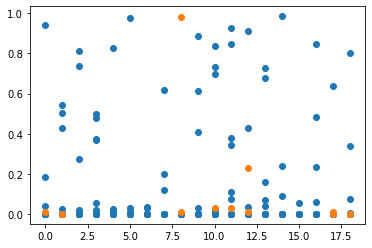

In [13]:
plt.scatter(data[:,0], data[:,1])
plt.scatter(z_next[:,0],z_next[:,1])


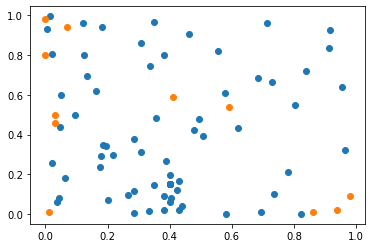

In [14]:
plt.scatter(data[:,2], data[:,3])
plt.scatter(z_next[:,2],z_next[:,3])


In [15]:
pd.DataFrame(Experiment_4_3mL).to_csv('./Round5/Actual_Round5_3mL.csv')

In [16]:
ModelBackground_4

{'gamma_list': [0.12240805375234246],
 'budget': 55,
 'bestUpperBoundEstimate': 36.666666666666664,
 'Wc_list_init': [array([9.33043857e-23, 1.00000000e+00, 1.00000000e+00, 2.30930052e-01,
         8.83155236e-01, 2.07583307e-17, 1.00000000e+00, 1.00000000e+00,
         1.00000000e+00, 2.34966751e-19, 1.71025103e-29, 1.26729582e-05,
         3.41029576e-67, 2.49470327e-11, 1.00000000e+00, 1.00000000e+00,
         9.83933212e-04, 1.00000000e+00, 1.23139243e-03])],
 'Wc_list': {0: [array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1.])],
  1: [array([1.03025917, 1.        , 1.        , 0.93039254, 0.9797444 ,
          1.02051546, 1.        , 1.        , 1.        , 1.01190571,
          1.0397624 , 1.00758561, 1.11013523, 1.        , 1.        ,
          1.01883888, 0.9533447 , 1.        , 0.98262115])],
  2: [array([1.03429477, 0.91996399, 1.00333434, 0.85573298, 0.9797444 ,
          1.02051546, 1.03265331, 1.        , 1.        , 1.01190571,
  

In [17]:
Carbon_Names[10]


'Rhamnose'

In [18]:
Carbon_Names[4]

'Mannose'